In [52]:
from itertools import chain

import torch
from torch import nn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score

plt.rcParams["font.family"] = ["Times New Roman","SimHei"]

In [53]:
batch_size = 16

In [54]:
model = torch.jit.load('CNN_model_scripted.pt')
# model = torch.jit.load('MLP_model_scripted.pt')

model.eval()
torch.set_grad_enabled(False)

criterion = nn.MSELoss()

In [55]:
# 读取数据


df = pd.read_csv("dataset_train.csv")

# 特征和标签
X_cols = [
    "Height (m MSL)",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
]
Y_col = "real_height"

# 取出特征和标签
data_X = df[X_cols].values
data_Y = df[Y_col].values

scaler = StandardScaler()


def normalize(data):
    data_no_height = X_cols.copy()
    data_no_height.remove("Height (m MSL)")
    data_X_scaled = df[data_no_height].values
    scaled_part = scaler.fit_transform(data_X_scaled)
    # 拼接未归一化的Height (m MSL)和归一化后的其他特征
    height_col = df[["Height (m MSL)"]].values
    # 保证顺序一致
    if X_cols[0] == "Height (m MSL)":
        reslut = np.concatenate([height_col, scaled_part], axis=1)
    else:
        # 若Height (m MSL)不在首位，需按X_cols顺序重组
        data_X_dict = {"Height (m MSL)": height_col}
        for i, col in enumerate(data_no_height):
            data_X_dict[col] = scaled_part[:, i:i+1]
        reslut = np.concatenate([data_X_dict[col] for col in X_cols], axis=1)

    return reslut

data_X = normalize(data_X) 

# 划分为训练集和测试集，确保不重合
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_Y, test_size=0.2, random_state=42, shuffle=True, stratify=None
)

# 检查GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 转为Tensor并放到DEVICE
train_X = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
train_Y = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
test_X = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
test_Y = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)

# 构建数据集和数据加载器
train_dataset = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = TensorDataset(test_X, test_Y)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

all_loader = chain(train_loader, test_loader)

print(f"All dataset size: {len(df)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

All dataset size: 119
Train dataset size: 95
Test dataset size: 24


In [56]:
# 计算平均误差
def get_error(loader):
    with torch.no_grad():
        model.eval()
        all_preds = []
        all_labels = []
        for batch_X, batch_Y in loader:
            pred = model(batch_X)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(batch_Y.cpu().numpy())
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        return np.mean(np.abs(all_preds - all_labels))


test_mean_error = get_error(test_loader)
print(f"Mean Absolute Error on Test Set: {test_mean_error:.4f}")

train_mean_error = get_error(train_loader)
print(f"Mean Absolute Error on Train Set: {train_mean_error:.4f}")

all_mean_error = get_error(
    chain(train_loader, test_loader) 
)
print(f"Mean Absolute Error on All Data: {all_mean_error:.4f}")

Mean Absolute Error on Test Set: 0.1496
Mean Absolute Error on Train Set: 0.1561
Mean Absolute Error on All Data: 0.1548


In [57]:
preds = []
labels = []
for batch_X, batch_Y in all_loader:
    pred = model(batch_X)
    preds.append(pred.cpu().numpy())
    labels.append(batch_Y.cpu().numpy())
preds = np.concatenate(preds, axis=0).flatten()
labels = np.concatenate(labels, axis=0).flatten()

MAE: 0.1548
RMSE: 0.2146
R² on Dataset: 0.9466


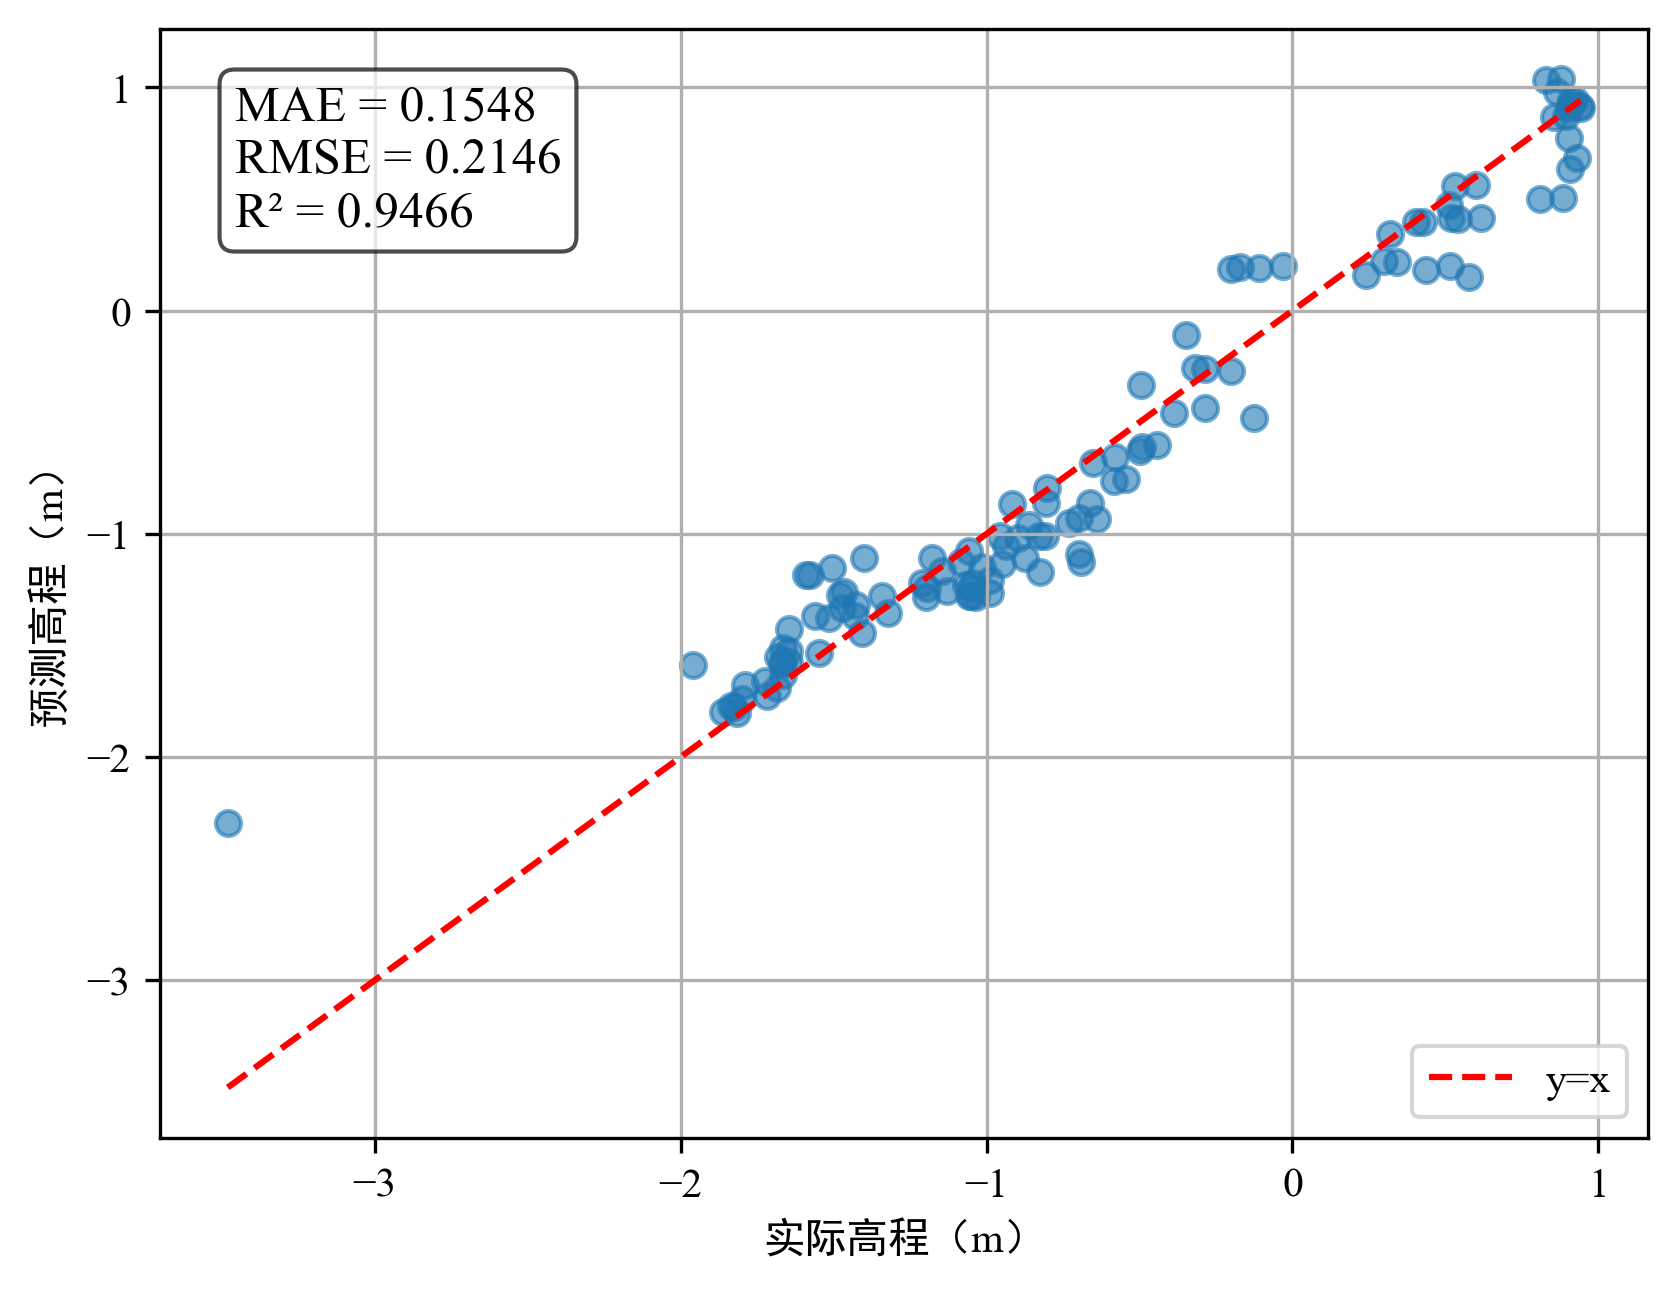

In [58]:
mae = np.mean(np.abs(preds - labels))
rmse = np.sqrt(np.mean((preds - labels) ** 2))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 计算R^2
r2 = r2_score(labels, preds)
print(f"R² on Dataset: {r2:.4f}")

# 绘制R^2图（散点图）
plt.figure(dpi=300)
plt.scatter(labels, preds, alpha=0.6)
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--', label='y=x')
plt.xlabel('实际高程（m）')
plt.ylabel('预测高程（m）')
info_text = f"MAE = {mae:.4f}\nRMSE = {rmse:.4f}\nR² = {r2:.4f}"
plt.text(
    0.05, 0.95, info_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
plt.legend()
plt.grid(True)
plt.show()

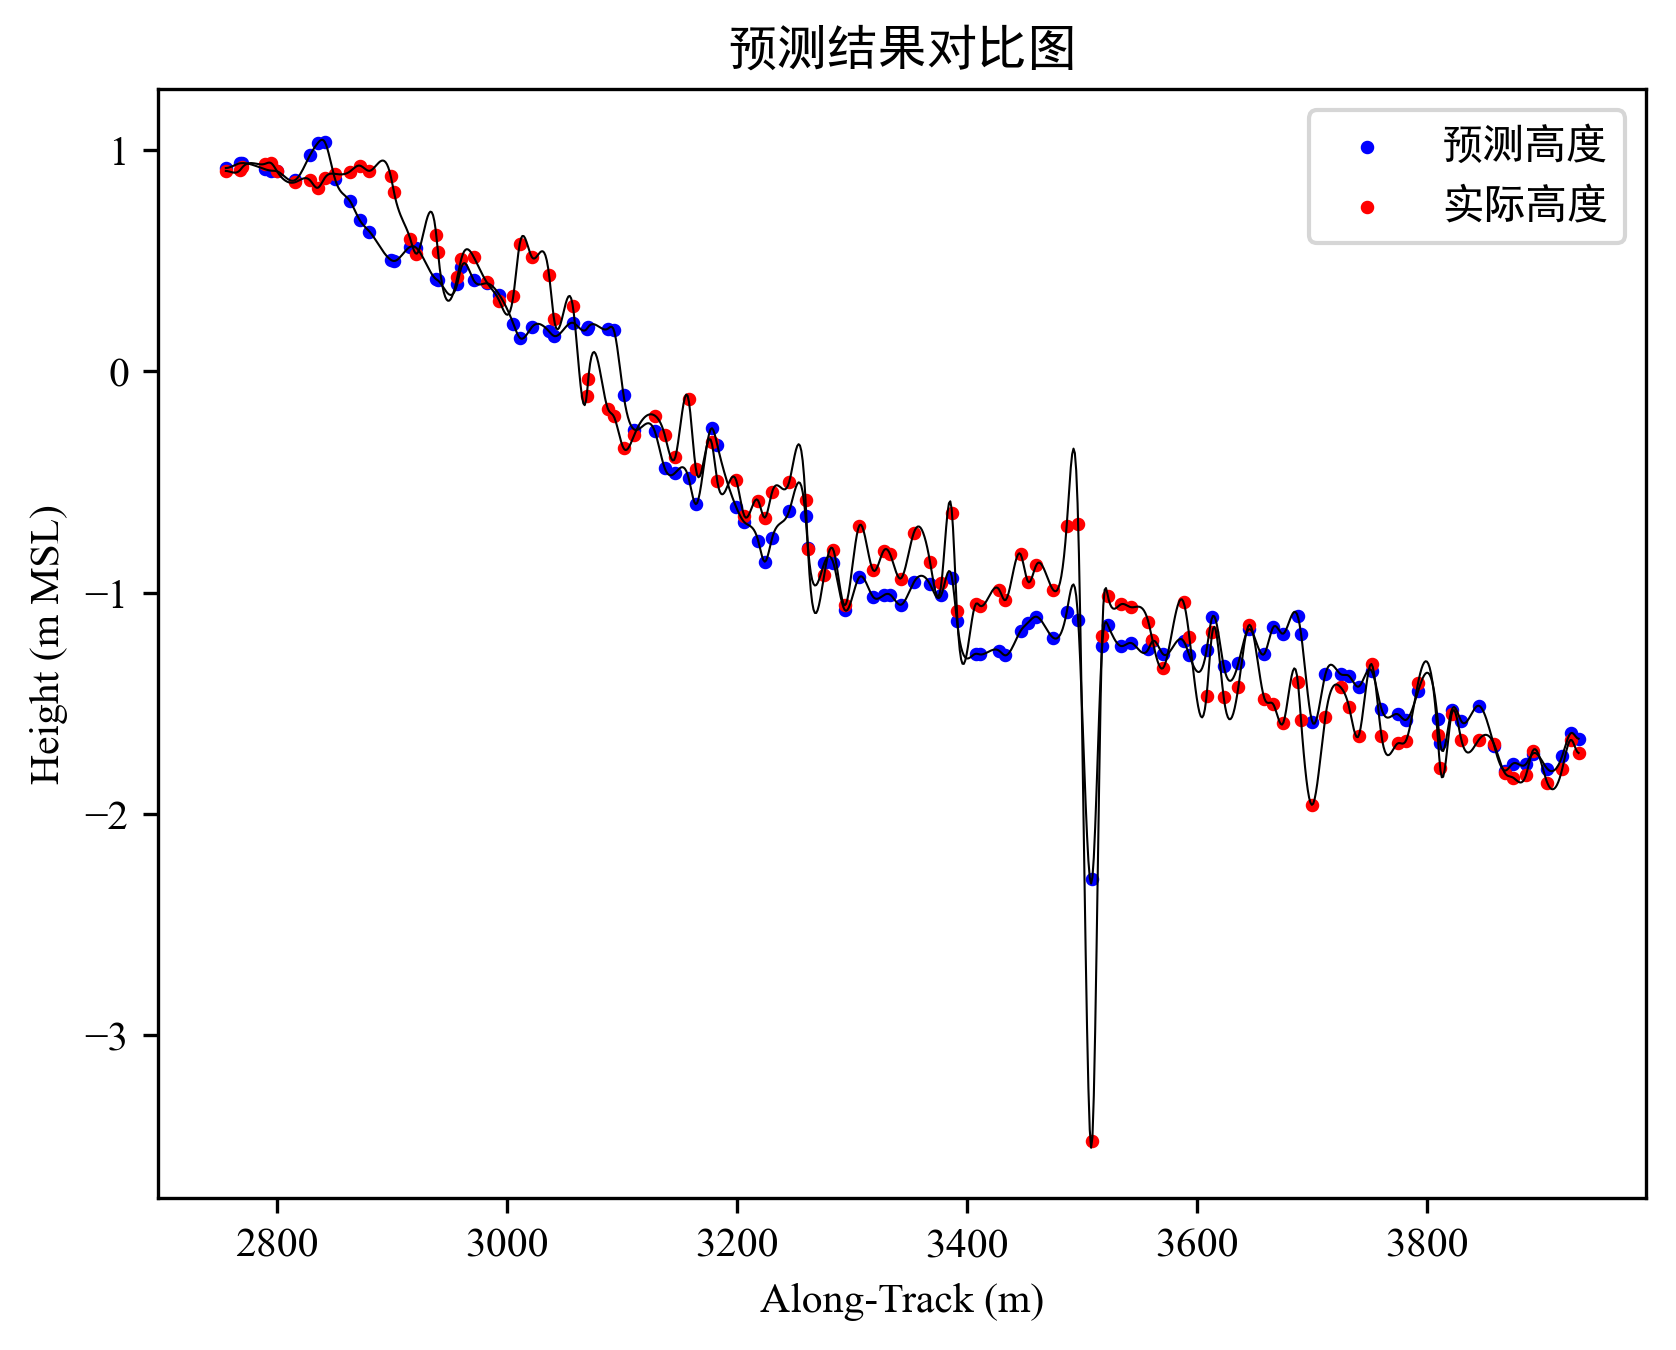

In [59]:
from scipy.interpolate import make_interp_spline

from utils.property import ICESAT2Properties

data_X = df[X_cols].values

data_X = normalize(data_X)
X = torch.tensor(data_X, dtype=torch.float32).to(DEVICE)

model.eval()
with torch.no_grad():
    # predictions = model(test_X).cpu().numpy().flatten()
    predictions = model(X).cpu().numpy().flatten()

fig, ax = plt.subplots(dpi=300)
plt.title("预测结果对比图")
plt.xlabel(ICESAT2Properties.AlongTrack.value)
plt.ylabel(ICESAT2Properties.Height_MSL.value)
ax.scatter(
    df[ICESAT2Properties.AlongTrack.value].values,
    predictions,
    label="预测高度",
    color="blue",
    s=5,
)
ax.scatter(
    df[ICESAT2Properties.AlongTrack.value].values,
    data_Y,
    label="实际高度",
    color="red",
    s=5,
)

# 插值曲线
interpolations: int = 1000
k: int = 3
bc_type: str = "clamped"
x_lable = ICESAT2Properties.AlongTrack.value

y = predictions
l = np.linspace(df[x_lable].min(), df[x_lable].max(), interpolations)
interpolation = make_interp_spline(df[x_lable], y, k=k, bc_type=bc_type)
y_hat = interpolation(l)
# 粉色
ax.plot(l, y_hat, color="black", linewidth=0.5)

y = data_Y
l = np.linspace(df[x_lable].min(), df[x_lable].max(), interpolations)
interpolation = make_interp_spline(df[x_lable], y, k=k, bc_type=bc_type)
y_hat = interpolation(l)
# 粉色
ax.plot(l, y_hat, color="black", linewidth=0.5)


plt.legend()
plt.show()